In [2]:
include("Main_module.jl")
using .TDQMC

In [3]:
using DataFrames, CSV, PyPlot

In [4]:
df = CSV.read("Ground_Guide_Wave.csv", DataFrame)
tr = Matrix(CSV.read("Ground_Trajectory.csv", DataFrame))

1×500 Matrix{Float64}:
 0.175251  0.698886  -1.09586  3.41988  …  0.711265  0.973121  -0.797173

In [5]:
Electron_num = size(tr, 1)
Ensemble_num = size(tr, 2)
Total_num = Electron_num * Ensemble_num

500

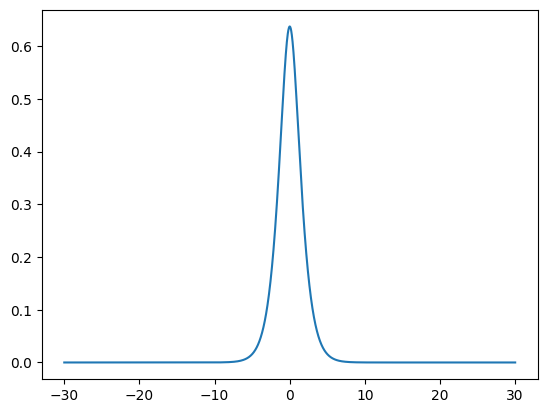

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\86187\.julia\packages\PyCall\3fwVL\src\numpy.jl:67
C:\Users\86187\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000073A1160>

In [6]:
initial_range = df[:, Total_num+1];         #最后一列保存的是空间的离散信息
Raw_Array = reshape(complex(Matrix(@. abs(parse(Complex{Float64}, df[:, 1:Total_num])))), (3001, Electron_num, Ensemble_num));          # 500代表的是系综*电子数的数目,因为是单电子所以不需要reshape
plot(initial_range, Raw_Array[:, 1, 1])

In [7]:
s_range = initial_range[end]
s_num = length(initial_range)

3001

In [8]:
l_range = 200.0
l_num = extend_num(s_range, l_range, s_num)

20001

In [9]:
P = Parameter{Float64,Int64}(space_N = l_num, scope = l_range, Δt = 0.02, step_t = 3000)

Parameter{Float64, Int64}(1, 500, [1, -1], 20001, 200.0, 0.02, 0.0008, range(-200.0, stop=200.0, length=20001), 0.02, 3000)

In [10]:
Raw_GuideWave = stitch_Matrix(Raw_Array, l_num)

1×500 Matrix{Vector{ComplexF64}}:
 [0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im  …  0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im]  …  [0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im  …  0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im]

In [14]:
Dy = Dynamics{Float64}(Trajectory = tr, Guide_Wave = Raw_GuideWave, Displace = zeros(eltype(tr), (P.step_t + 1, Ensemble_num, Electron_num)));
df = nothing
Raw_DuideWave = nothing
Raw_Array = nothing
tr = nothing
GC.gc()

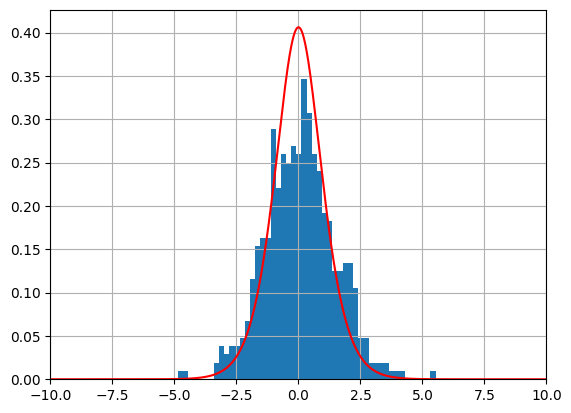

(-10.0, 10.0)

In [24]:
hist(Dy.Trajectory', 50, density = true);
plot(P.sampling, abs2.(Dy.Guide_Wave[1]), color = "red")      #说明长度能够吻合上
grid()
xlim(-10, 10)

In [ ]:
parallel_Evolution!(P, Dy)